# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

# Дз 1

Перед нами стоит задача обучить линейную регрессию и проверить её валидность, т.е. хорошо ли и как хорошо она описывает наши данные. В своём решении я пользуюсь метрикой MSE, оценивать качество буду коэфициентом детерминации. 

In [54]:
import numpy as np
import random
from tqdm.notebook import tqdm

In [55]:
%matplotlib inline

In [56]:
import matplotlib.pyplot as plt

In [57]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

In [58]:
# Нормализация - приведение к отрезку [0, 1]
# с ней минимальный loss был ~ 45
Xtr = Xtr - Xtr.min(axis=0)
Xtr = Xtr / Xtr.max(axis=0)

In [59]:
# Нормализация - стандартизация
# здесь минимальный лос доходил до ~ 3
Xtr = (Xtr - Xtr.mean(axis=0)) / Xtr.std(axis=0)

### Визуализация распределения признаков

Из визуализации распределения признаков мы можем сделать вывод о их корреляции

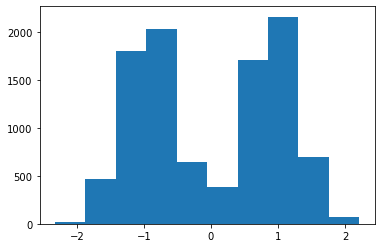

In [60]:
plt.hist(Xtr[:, 0])
None

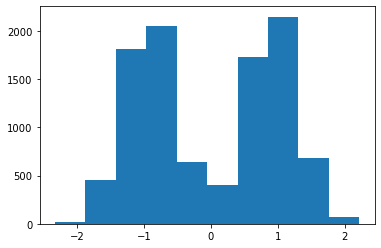

In [61]:
plt.hist(Xtr[:, 1])
None

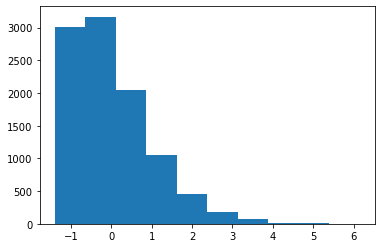

In [62]:
plt.hist(Xtr[:, 2])
None

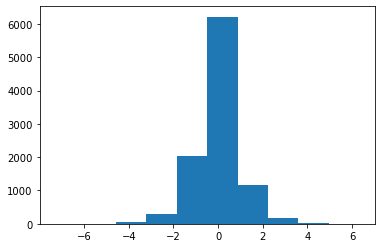

In [63]:
plt.hist(Xtr[:, 3])
None

У нас прослеживается корреляция только между первым и вторым признаками,
поэтому от отдного из них мы избавимся. Между другими зависимости замечено 
не было, их оставляем как есть

In [64]:
# удаляем первый столбец в матрице
Xtr = np.delete(Xtr, 0, axis=1)

In [65]:
# добавляем фиктивный признак в Xtr для того,
# чтобы был свободный член в коеф. тета 
additional = [[1] for i in range(Xtr.shape[0])]
Xtr = np.append(Xtr, additional, axis=1)

### Разбиваем на обучающую и тестовые выборки 

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.15)

### Реализация классов линейной регрессии

In [67]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [68]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):
        # Этот метод реализует вычисление значения функции потерь
        loss_value = (y_true - y_pred)**2
        return sum(loss_value) / y_true.shape[0]
    
    
    def backward(self, y_pred, y_true):
        # Этот метод реализует вычисление градиента функции потерь по аргументу y_pred
        partial_grad = y_pred - y_true
        return partial_grad

In [69]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def backward(self, X):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        partial_grad = X.T
        return partial_grad
    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            self.theta = np.random.sample(X.shape[1])
            self.theta = self.theta.reshape((X.shape[1], 1))
            
        y_pred = np.dot(X, self.theta)
        return y_pred

In [70]:
def train_loop(X, y, model, loss_fn, epochs=100):
    loss_history = np.array([])
    pbar = tqdm(total=epochs)
    # learnig rate
    lr = 0.0001

    for epoch in range(epochs):
        # предсказываем нашей молелью выходной параметр
        y_pred = model.forward(X)
        loss_value = loss_fn.forward(y_pred, y)
        
        grad = lr * np.dot(model.backward(X), loss_fn.backward(y_pred, y))
        model.theta -= grad
        
        loss_history = np.append(loss_history, loss_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
        
    pbar.close()
    return loss_history

### Обучение модели и построение графика Loss

In [71]:
obj_fn = loss()
lr_model = linear_regression()
loss_history = train_loop(X_train, y_train, lr_model, obj_fn, epochs=1000)

Немного поигравшись с LR мы получаем минимальный Loss ~0.52 <p>
Для этого мы удалили один из коррелирующий столбцов признаков, выставили lr = 0.0001. Стоит отметить, что при большем lr градиент улетал в бесконечность, а при меньших мы не достигали минимума ф-ции так быстро


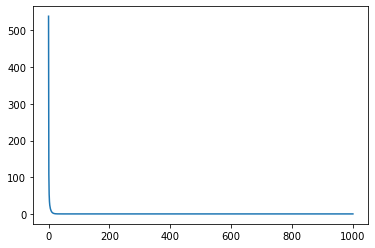

In [72]:
x = np.linspace(0, 1000, 1000)
plt.plot(x, loss_history)

### Проверка качества модели

In [73]:
y_pred = lr_model.forward(X_test)
test_loss = obj_fn.forward(y_pred, y_test)[0]
print(test_loss)

0.5148903982000679


In [74]:
print("Test loss = {}".format(test_loss), end='\n')
print("Train loss = {}".format(loss_history[-1]), end='\n')

Test loss = 0.5148903982000679
Train loss = 0.5281269973871218


In [98]:
from sklearn.metrics import r2_score

print("Test R2 metrics {}".format(r2_score(y_test, y_pred)))

Test R2 metrics 0.9987214606899534


В итоге мы видим, что потери на тестовой выборке почти такие же как на тренировочной. Делаем из этого вывод, что наша линейная регрессия не переобучилась и оценивает все признаки с хорошей точностью

### Вывод

Наша модель прекрасно подходит для описания получаемых нами данных, как можно увидеть из данных о loss <p>
Данных нам было передано изботочное количество, потому что два признака коррелировали и от одного нам было необходимо избавляться. Так же как видно из графика loss мы могли бы достичь того же результата даже при много меньшем числе данных <P>
При проверке на test выборке переобучения не было обнаружено, модель хорошо справляется со всеми видами признаков. 